<a href="https://colab.research.google.com/github/RMCV-Rajapaksha/TeamInception_Datathon/blob/main/task2_eda_and_data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 Notebook for "insert model name here"


## Imports and Setup

**Import the Libararies**


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

### Reading data set files

In [2]:
# Developers please update the paths according to were in your google you place datasets
# i recommend making Rootcode-ML folder and in it Datasets folder and placing the csv files there then you wont have to change below code block
bookings_data = pd.read_csv('../dataset/bookings_train.csv')
tasks_data = pd.read_csv('../dataset/tasks.csv')
staffing_data = pd.read_csv('../dataset/staffing_train.csv')

In [3]:
bookings_data.head()

,booking_id,citizen_id,booking_date,appointment_date,appointment_time,check_in_time,check_out_time,task_id,num_documents,queue_number,satisfaction_rating
0,f7b59ba3793fea61282cb02be2247cebd0a75306,4229044420,2021-01-01,2021-01-01,09:03,2021-01-01 09:11:00,2021-01-01 09:48:15.166353269,TASK-002,0,2,4
1,cfe30d53b4b645e4cb6b114f6c9d74a0f25e6a80,5389442635,2021-01-01,2021-01-01,09:12,2021-01-01 09:24:00,2021-01-01 10:24:12.189261137,TASK-001,1,1,4
2,0fb0a5d9b3944dd743a9e7828dc03fa74aa6ebf8,2123783919,2021-01-01,2021-01-01,09:36,2021-01-01 09:29:00,2021-01-01 10:26:48.802260864,TASK-002,1,6,5
3,d4bf826153212fa325ad98b215668ab942365607,6359918966,2021-01-01,2021-01-01,09:45,2021-01-01 10:07:00,2021-01-01 11:00:13.485642822,TASK-001,1,4,4
4,ebb4c9687acbaf65376d8e379bd1341d1c15127e,178732202,2021-01-01,2021-01-01,10:12,2021-01-01 10:26:00,2021-01-01 11:54:53.260180213,TASK-002,1,8,3


## EDA


### EDA of Bookings data

lets take a look at the columns and some of their values

In [4]:
staffing_data.head()

,date,section_id,employees_on_duty,total_task_time_minutes
0,2021-01-01,SEC-001,1,834.569483
1,2021-01-01,SEC-002,4,1525.368990
2,2021-01-01,SEC-003,2,662.095279
3,2021-01-01,SEC-004,4,1499.112620
4,2021-01-01,SEC-005,3,1238.533073


In [5]:
staffing_data.describe()

,employees_on_duty,total_task_time_minutes
count,5802.000000,5802.000000
mean,4.458807,1662.296769
std,2.794417,1147.134643
min,1.000000,91.109596
25%,3.000000,859.104314
50%,4.000000,1358.176924
75%,6.000000,2123.936358
max,26.000000,10658.173092


removing unnecessary columns. We wont need the total_task_time_minutes because this data wont be provided as input from the test datasets. We need the date and section_id  because they will be to calculate the actual target value (the thing to be predicted) for task 2.

In [6]:
staffing_data = staffing_data.drop(['total_task_time_minutes'],axis=1)

now lets look at the new table headers again.


In [7]:
staffing_data.head()

,date,section_id,employees_on_duty
0,2021-01-01,SEC-001,1
1,2021-01-01,SEC-002,4
2,2021-01-01,SEC-003,2
3,2021-01-01,SEC-004,4
4,2021-01-01,SEC-005,3


lets get a better idea of how null values have been distributed amoung the columns

In [8]:
staffing_data.isna().sum()

date                 0
section_id           0
employees_on_duty    0
dtype: int64

## Data Preprocessing


### Rearrangement and processing of columns

### Dataset seperation according to section_id

In [9]:
task_counts = staffing_data.groupby("section_id").size().reset_index(name="count")
task_counts

,section_id,count
0,SEC-001,967
1,SEC-002,967
2,SEC-003,967
3,SEC-004,967
4,SEC-005,967
5,SEC-006,967


In [10]:
sec_1_data = staffing_data[staffing_data['section_id'] == 'SEC-001'].copy()
sec_2_data = staffing_data[staffing_data['section_id'] == 'SEC-002'].copy()
sec_3_data = staffing_data[staffing_data['section_id'] == 'SEC-003'].copy()
sec_4_data = staffing_data[staffing_data['section_id'] == 'SEC-004'].copy()
sec_5_data = staffing_data[staffing_data['section_id'] == 'SEC-005'].copy()
sec_6_data = staffing_data[staffing_data['section_id'] == 'SEC-006'].copy()


In [11]:
sec_6_data.head()

,date,section_id,employees_on_duty
5,2021-01-01,SEC-006,11
11,2021-01-04,SEC-006,6
17,2021-01-05,SEC-006,5
23,2021-01-06,SEC-006,10
29,2021-01-07,SEC-006,5


In [12]:
class ManualDifferencingARIMA:
    """
    ARIMA with manual differencing and integration control
    This gives you better control over the stationarity process
    """
    
    def __init__(self, data, target_column, section_name):
        self.data = data.copy()
        self.target_column = target_column
        self.section_name = section_name
        self.original_series = data[target_column].copy()
        self.differenced_series = None
        self.differencing_order = 0
        self.seasonal_period = 7  # Weekly seasonality
        self.model = None
        self.last_values = []  # Store values needed for integration
        
    def test_stationarity(self, series, title="Series"):
        """Test stationarity using ADF and KPSS tests"""
        print(f"\n=== STATIONARITY TEST FOR {title.upper()} ===")
        
        # ADF Test
        adf_result = adfuller(series.dropna())
        print(f"ADF Test Results:")
        print(f"  ADF Statistic: {adf_result[0]:.6f}")
        print(f"  p-value: {adf_result[1]:.6f}")
        print(f"  Critical Values: {adf_result[4]}")
        adf_stationary = adf_result[1] <= 0.05
        print(f"  Stationary (ADF): {'YES' if adf_stationary else 'NO'}")
        
        # KPSS Test
        try:
            kpss_result = kpss(series.dropna(), regression='ct')
            print(f"\nKPSS Test Results:")
            print(f"  KPSS Statistic: {kpss_result[0]:.6f}")
            print(f"  p-value: {kpss_result[1]:.6f}")
            print(f"  Critical Values: {kpss_result[3]}")
            kpss_stationary = kpss_result[1] >= 0.05
            print(f"  Stationary (KPSS): {'YES' if kpss_stationary else 'NO'}")
            
            # Both tests should agree for true stationarity
            is_stationary = adf_stationary and kpss_stationary
            print(f"\nOVERALL STATIONARITY: {'YES' if is_stationary else 'NO'}")
            
        except:
            print("KPSS test failed, relying on ADF test only")
            is_stationary = adf_stationary
            
        return is_stationary
    
    def apply_differencing(self, max_diff=3):
        """Apply differencing until series becomes stationary"""
        print(f"\n{'='*60}")
        print(f"APPLYING DIFFERENCING FOR {self.section_name}")
        print(f"{'='*60}")
        
        current_series = self.original_series.copy()
        self.differencing_order = 0
        
        # Test original series
        is_stationary = self.test_stationarity(current_series, "Original Series")
        
        if is_stationary:
            print("Series is already stationary!")
            self.differenced_series = current_series
            return current_series
        
        # Apply differencing iteratively
        for d in range(1, max_diff + 1):
            print(f"\n--- Applying {d}th order differencing ---")
            current_series = current_series.diff().dropna()
            
            is_stationary = self.test_stationarity(current_series, f"{d}th Differenced Series")
            
            if is_stationary:
                print(f"\n✅ Series became stationary after {d} differencing steps!")
                self.differencing_order = d
                self.differenced_series = current_series
                
                # Store last values needed for integration
                if d == 1:
                    self.last_values = [self.original_series.iloc[-1]]
                elif d == 2:
                    self.last_values = [self.original_series.iloc[-1], self.original_series.iloc[-2]]
                elif d == 3:
                    self.last_values = [self.original_series.iloc[-1], self.original_series.iloc[-2], self.original_series.iloc[-3]]
                
                return current_series
        
        # If still not stationary after max_diff
        print(f"\n⚠️  Series still not stationary after {max_diff} differencing steps!")
        print("Using the most differenced version...")
        self.differencing_order = max_diff
        self.differenced_series = current_series
        
        return current_series
    
    def visualize_differencing_process(self):
        """Visualize the differencing process"""
        fig, axes = plt.subplots(self.differencing_order + 1, 1, figsize=(15, 4*(self.differencing_order + 1)))
        
        if self.differencing_order == 0:
            axes = [axes]  # Make it iterable
        
        # Plot original series
        axes[0].plot(self.original_series.index, self.original_series, 'b-', linewidth=1)
        axes[0].set_title(f'{self.section_name} - Original Series')
        axes[0].grid(True, alpha=0.3)
        
        # Plot differenced series
        current_series = self.original_series.copy()
        for d in range(1, self.differencing_order + 1):
            current_series = current_series.diff().dropna()
            axes[d].plot(current_series.index, current_series, 'r-', linewidth=1)
            axes[d].set_title(f'{self.section_name} - {d}th Order Differenced Series')
            axes[d].grid(True, alpha=0.3)
            axes[d].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()
    
    def find_best_arima_params(self, max_p=5, max_q=5):
        """Find best AR and MA parameters for the differenced stationary series"""
        print(f"\n{'='*50}")
        print(f"FINDING OPTIMAL ARIMA PARAMETERS")
        print(f"{'='*50}")
        
        if self.differenced_series is None:
            raise ValueError("Must apply differencing first!")
        
        best_aic = float('inf')
        best_params = None
        results = []
        
        print(f"Testing parameters with d={self.differencing_order} (fixed from differencing)")
        print(f"Searching p from 0 to {max_p}, q from 0 to {max_q}")
        
        for p in range(max_p + 1):
            for q in range(max_q + 1):
                try:
                    # Fit ARIMA(p,0,q) on the already differenced data
                    model = ARIMA(self.differenced_series, order=(p, 0, q))
                    fitted_model = model.fit()
                    
                    aic = fitted_model.aic
                    bic = fitted_model.bic
                    
                    results.append({
                        'p': p, 'd': self.differencing_order, 'q': q,
                        'AIC': aic, 'BIC': bic
                    })
                    
                    if aic < best_aic:
                        best_aic = aic
                        best_params = (p, self.differencing_order, q)
                        self.model = fitted_model
                        
                except Exception as e:
                    continue
        
        results_df = pd.DataFrame(results)
        if not results_df.empty:
            print("\nTop 5 models by AIC:")
            print(results_df.nsmallest(5, 'AIC'))
        
        print(f"\nBest ARIMA parameters: {best_params}")
        print(f"Best AIC: {best_aic:.2f}")
        
        return best_params
    
    def integrate_predictions(self, differenced_predictions):
        """
        Manually integrate the predictions back to original scale
        This is the inverse of differencing
        """
        if self.differencing_order == 0:
            return differenced_predictions
        
        integrated_predictions = []
        
        # Get the last values from the original series
        if self.differencing_order == 1:
            # For 1st order differencing: pred[t] = pred_diff[t] + actual[t-1]
            last_value = self.last_values[0]
            integrated_predictions.append(last_value + differenced_predictions[0])
            
            for i in range(1, len(differenced_predictions)):
                next_value = integrated_predictions[-1] + differenced_predictions[i]
                integrated_predictions.append(next_value)
                
        elif self.differencing_order == 2:
            # For 2nd order differencing: more complex integration
            # First integrate once
            first_integration = []
            last_diff = self.original_series.diff().iloc[-1]
            first_integration.append(last_diff + differenced_predictions[0])
            
            for i in range(1, len(differenced_predictions)):
                next_diff = first_integration[-1] + differenced_predictions[i]
                first_integration.append(next_diff)
            
            # Then integrate again to get final values
            last_value = self.last_values[0]
            integrated_predictions.append(last_value + first_integration[0])
            
            for i in range(1, len(first_integration)):
                next_value = integrated_predictions[-1] + first_integration[i]
                integrated_predictions.append(next_value)
        
        return np.array(integrated_predictions)
    
    def train_test_split(self, train_ratio=0.7, val_ratio=0.15):
        """Split the data maintaining time series order"""
        n = len(self.data)
        train_size = int(n * train_ratio)
        val_size = int(n * val_ratio)
        
        self.train_data = self.data.iloc[:train_size].copy()
        self.val_data = self.data.iloc[train_size:train_size + val_size].copy()
        self.test_data = self.data.iloc[train_size + val_size:].copy()
        
        print(f"\nData split for {self.section_name}:")
        print(f"Training: {len(self.train_data)} samples")
        print(f"Validation: {len(self.val_data)} samples")
        print(f"Test: {len(self.test_data)} samples")
        
        return self.train_data, self.val_data, self.test_data
    
    def fit_and_predict(self):
        """Complete training and prediction pipeline"""
        print(f"\n{'='*60}")
        print(f"COMPLETE PIPELINE FOR {self.section_name}")
        print(f"{'='*60}")
        
        # Step 1: Split the data
        self.train_test_split()
        
        # Step 2: Apply differencing to training data only
        train_series = self.train_data[self.target_column].copy()
        self.original_series = train_series  # Update to training series
        stationary_series = self.apply_differencing()
        
        # Step 3: Visualize the differencing process
        self.visualize_differencing_process()
        
        # Step 4: Find optimal parameters
        best_params = self.find_best_arima_params()
        
        # Step 5: Make predictions on validation and test sets
        n_val = len(self.val_data)
        n_test = len(self.test_data)
        
        # Predict on differenced scale
        val_pred_diff = self.model.forecast(steps=n_val)
        test_pred_diff = self.model.forecast(steps=n_test)
        
        # Step 6: Integrate back to original scale
        val_pred_integrated = self.integrate_predictions(val_pred_diff)
        test_pred_integrated = self.integrate_predictions(test_pred_diff)
        
        # Calculate metrics
        val_mae = mean_absolute_error(self.val_data[self.target_column], val_pred_integrated)
        val_rmse = np.sqrt(mean_squared_error(self.val_data[self.target_column], val_pred_integrated))
        val_mape = np.mean(np.abs((self.val_data[self.target_column] - val_pred_integrated) / self.val_data[self.target_column])) * 100
        
        test_mae = mean_absolute_error(self.test_data[self.target_column], test_pred_integrated)
        test_rmse = np.sqrt(mean_squared_error(self.test_data[self.target_column], test_pred_integrated))
        test_mape = np.mean(np.abs((self.test_data[self.target_column] - test_pred_integrated) / self.test_data[self.target_column])) * 100
        
        print(f"\n{'='*50}")
        print(f"RESULTS FOR {self.section_name}")
        print(f"{'='*50}")
        print(f"Differencing Order Used: {self.differencing_order}")
        print(f"Final ARIMA Parameters: {best_params}")
        print(f"Validation - MAE: {val_mae:.2f}, RMSE: {val_rmse:.2f}, MAPE: {val_mape:.2f}%")
        print(f"Test - MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, MAPE: {test_mape:.2f}%")
        
        # Store results
        self.results = {
            'best_params': best_params,
            'differencing_order': self.differencing_order,
            'val_pred': val_pred_integrated,
            'test_pred': test_pred_integrated,
            'val_metrics': {'MAE': val_mae, 'RMSE': val_rmse, 'MAPE': val_mape},
            'test_metrics': {'MAE': test_mae, 'RMSE': test_rmse, 'MAPE': test_mape}
        }
        
        return self.results
    
    def plot_results(self):
        """Plot the final results"""
        fig, axes = plt.subplots(2, 1, figsize=(15, 12))
        
        # Plot 1: Complete time series with predictions
        ax1 = axes[0]
        ax1.plot(self.train_data.index, self.train_data[self.target_column], 
                label='Training', color='blue', alpha=0.7, linewidth=1.5)
        ax1.plot(self.val_data.index, self.val_data[self.target_column], 
                label='Validation Actual', color='green', alpha=0.8, linewidth=2)
        ax1.plot(self.test_data.index, self.test_data[self.target_column], 
                label='Test Actual', color='red', alpha=0.8, linewidth=2)
        ax1.plot(self.val_data.index, self.results['val_pred'], 
                label='Validation Predicted', color='lightgreen', linestyle='--', linewidth=2)
        ax1.plot(self.test_data.index, self.results['test_pred'], 
                label='Test Predicted', color='orange', linestyle='--', linewidth=2)
        
        ax1.set_title(f'{self.section_name} - Manual Differencing ARIMA Results')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_ylabel('Employees on Duty')
        
        # Plot 2: Residuals
        ax2 = axes[1]
        val_residuals = self.val_data[self.target_column].values - self.results['val_pred']
        test_residuals = self.test_data[self.target_column].values - self.results['test_pred']
        
        ax2.plot(self.val_data.index, val_residuals, 'go-', alpha=0.7, label='Validation Residuals')
        ax2.plot(self.test_data.index, test_residuals, 'ro-', alpha=0.7, label='Test Residuals')
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.8)
        ax2.set_title('Prediction Residuals')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylabel('Residuals')
        ax2.set_xlabel('Date')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print(f"\nSummary for {self.section_name}:")
        print(f"Original series required {self.differencing_order} differencing steps to become stationary")
        print(f"Final model: ARIMA{self.results['best_params']}")
        print(f"Test MAPE: {self.results['test_metrics']['MAPE']:.2f}%")

# Usage function for all sections
def process_all_sections_manual_differencing(sections_data):
    """Process all sections with manual differencing approach"""
    results_summary = {}
    
    for section_name, data in sections_data.items():
        print(f"\n{'='*80}")
        print(f"PROCESSING {section_name} WITH MANUAL DIFFERENCING")
        print(f"{'='*80}")
        
        # Initialize the manual differencing ARIMA
        arima_manual = ManualDifferencingARIMA(data, 'employees_on_duty', section_name)
        
        # Fit and predict
        results = arima_manual.fit_and_predict()
        
        # Plot results
        arima_manual.plot_results()
        
        # Store results
        results_summary[section_name] = results
    
    return results_summary

# Example usage:
# sections_data = {
#     'SEC-001': sec_1_data,
#     'SEC-002': sec_2_data,
#     'SEC-003': sec_3_data,
#     'SEC-004': sec_4_data,
#     'SEC-005': sec_5_data,
#     'SEC-006': sec_6_data
# }
# 
# enhanced_results = process_all_sections_manual_differencing(sections_data)

def compare_results(manual_results, original_results=None):
    """Compare manual differencing results with original approach"""
    print(f"\n{'='*80}")
    print("MANUAL DIFFERENCING ARIMA - PERFORMANCE SUMMARY")
    print(f"{'='*80}")
    
    summary_data = []
    for section_name, results in manual_results.items():
        summary_data.append({
            'Section': section_name,
            'Differencing_Order': results['differencing_order'],
            'ARIMA_Params': results['best_params'],
            'Val_MAPE': results['val_metrics']['MAPE'],
            'Test_MAPE': results['test_metrics']['MAPE'],
            'Test_MAE': results['test_metrics']['MAE'],
            'Test_RMSE': results['test_metrics']['RMSE']
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
    # Calculate averages
    print(f"\nAverage Performance:")
    print(f"Average Test MAPE: {summary_df['Test_MAPE'].mean():.2f}%")
    print(f"Average Test MAE: {summary_df['Test_MAE'].mean():.2f}")
    print(f"Average Test RMSE: {summary_df['Test_RMSE'].mean():.2f}")
    
    return summary_df

Starting Manual Differencing ARIMA Analysis...

PROCESSING SEC-001 WITH MANUAL DIFFERENCING

COMPLETE PIPELINE FOR SEC-001

Data split for SEC-001:
Training: 676 samples
Validation: 145 samples
Test: 146 samples

APPLYING DIFFERENCING FOR SEC-001

=== STATIONARITY TEST FOR ORIGINAL SERIES ===
ADF Test Results:
  ADF Statistic: -24.469952
  p-value: 0.000000
  Critical Values: {'1%': np.float64(-3.4400749518321394), '5%': np.float64(-2.865831348847229), '10%': np.float64(-2.5690552762688617)}
  Stationary (ADF): YES

KPSS Test Results:
  KPSS Statistic: 0.105058
  p-value: 0.100000
  Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
  Stationary (KPSS): YES

OVERALL STATIONARITY: YES
Series is already stationary!


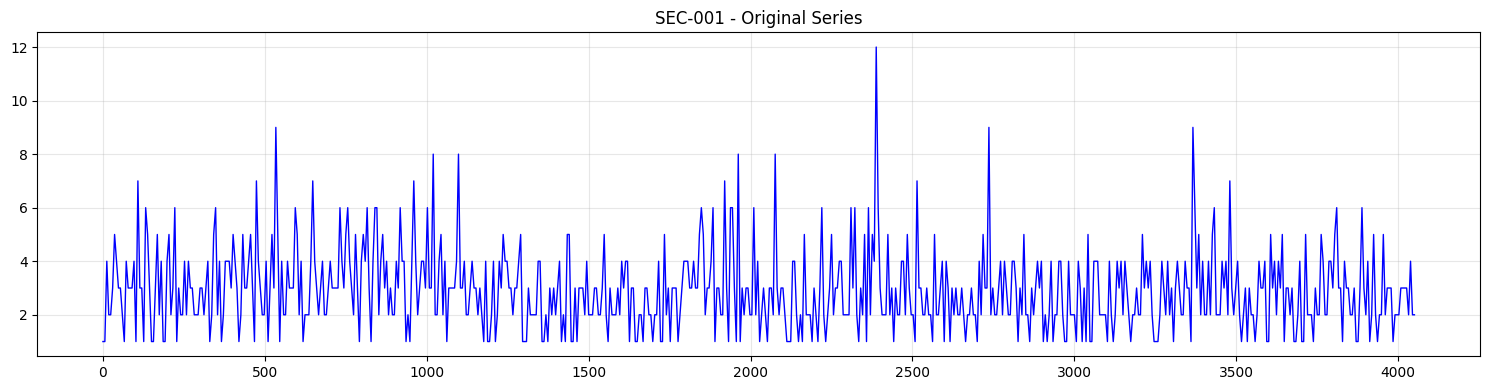


FINDING OPTIMAL ARIMA PARAMETERS
Testing parameters with d=0 (fixed from differencing)
Searching p from 0 to 5, q from 0 to 5

Top 5 models by AIC:
    p  d  q          AIC          BIC
19  3  0  1  2471.485649  2498.582807
9   1  0  3  2471.549114  2498.646273
15  2  0  3  2471.581480  2503.194831
20  3  0  2  2471.759168  2503.372519
21  3  0  3  2472.415194  2508.544739

Best ARIMA parameters: (3, 0, 1)
Best AIC: 2471.49

RESULTS FOR SEC-001
Differencing Order Used: 0
Final ARIMA Parameters: (3, 0, 1)
Validation - MAE: 1.01, RMSE: 1.32, MAPE: nan%
Test - MAE: 1.05, RMSE: 1.44, MAPE: nan%


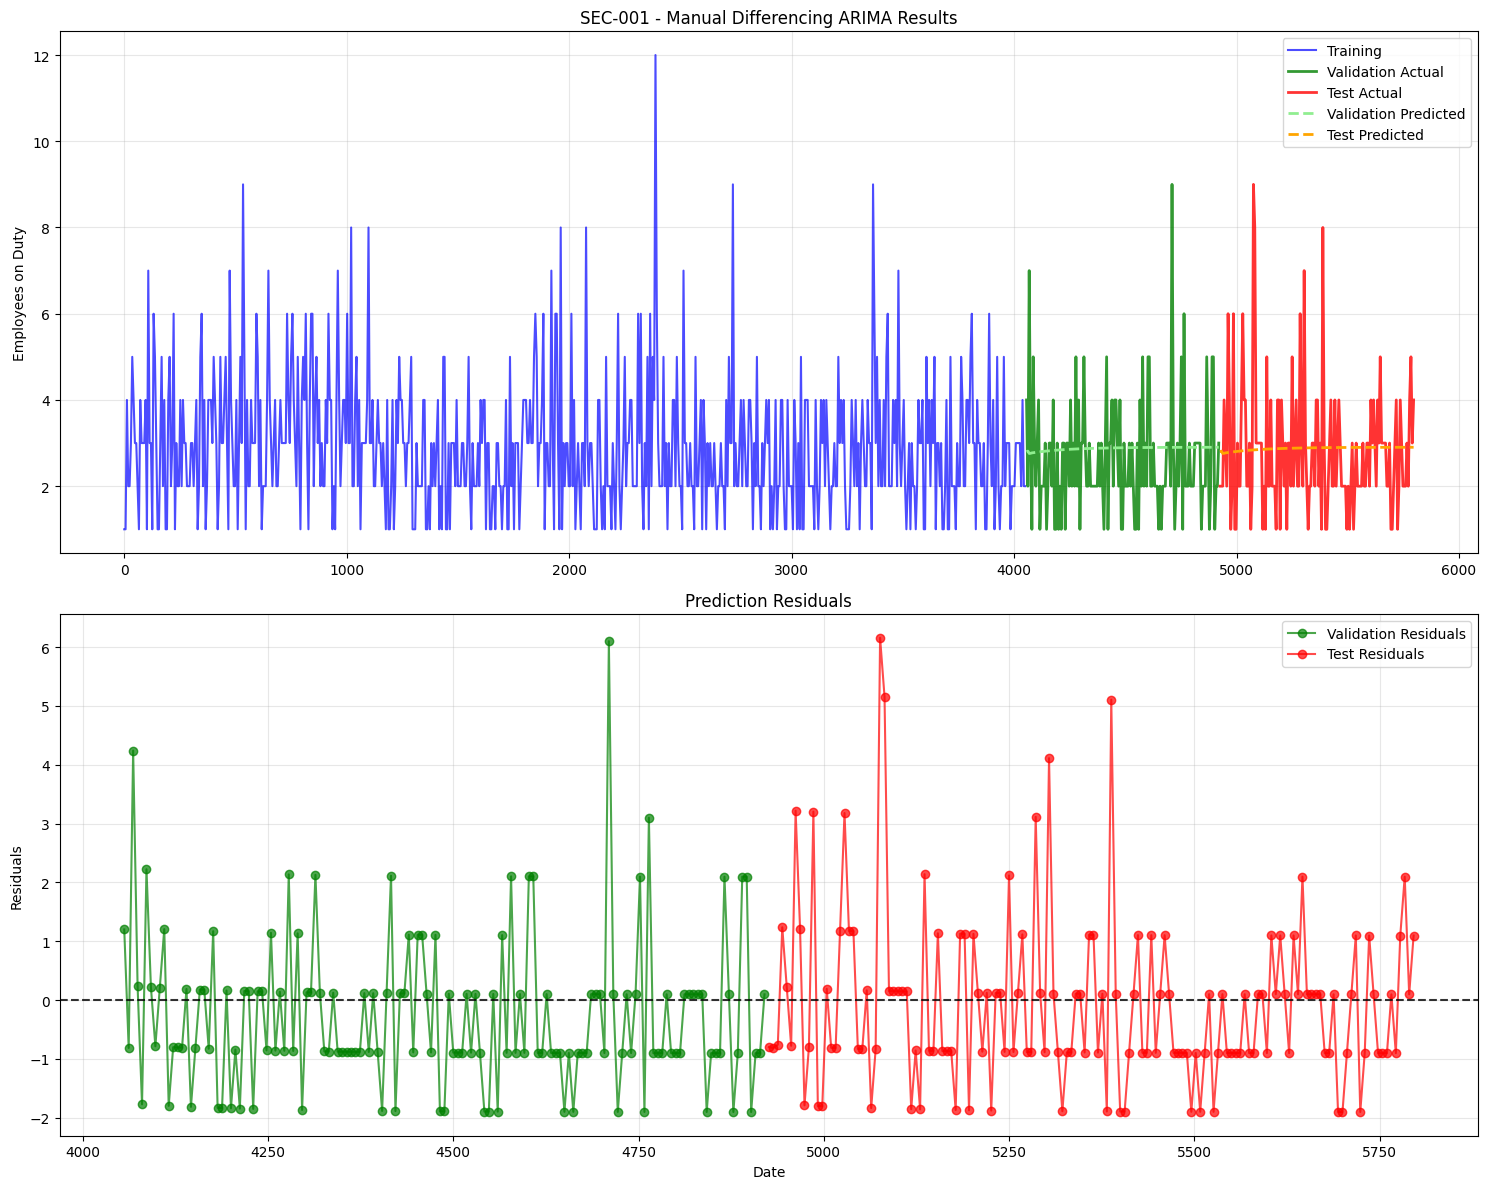


Summary for SEC-001:
Original series required 0 differencing steps to become stationary
Final model: ARIMA(3, 0, 1)
Test MAPE: nan%

PROCESSING SEC-002 WITH MANUAL DIFFERENCING

COMPLETE PIPELINE FOR SEC-002

Data split for SEC-002:
Training: 676 samples
Validation: 145 samples
Test: 146 samples

APPLYING DIFFERENCING FOR SEC-002

=== STATIONARITY TEST FOR ORIGINAL SERIES ===
ADF Test Results:
  ADF Statistic: -9.812083
  p-value: 0.000000
  Critical Values: {'1%': np.float64(-3.4401478069875613), '5%': np.float64(-2.8658634456698464), '10%': np.float64(-2.5690723769213633)}
  Stationary (ADF): YES

KPSS Test Results:
  KPSS Statistic: 0.053600
  p-value: 0.100000
  Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
  Stationary (KPSS): YES

OVERALL STATIONARITY: YES
Series is already stationary!


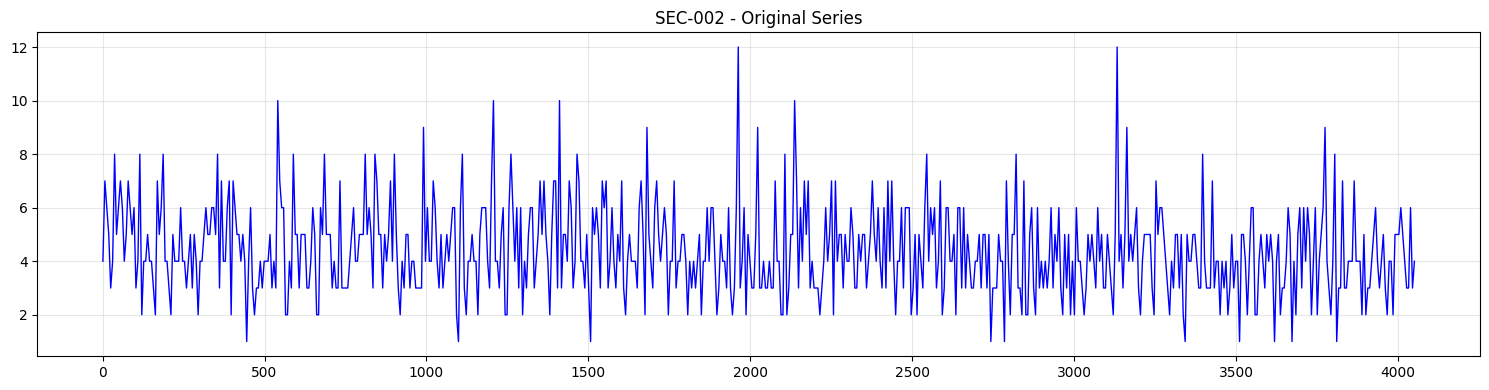


FINDING OPTIMAL ARIMA PARAMETERS
Testing parameters with d=0 (fixed from differencing)
Searching p from 0 to 5, q from 0 to 5

Top 5 models by AIC:
    p  d  q          AIC          BIC
29  4  0  5  2604.124358  2653.802481
34  5  0  4  2604.637271  2654.315395
14  2  0  2  2605.892267  2632.989425
33  5  0  3  2606.113792  2651.275723
23  3  0  5  2606.634154  2651.796085

Best ARIMA parameters: (4, 0, 5)
Best AIC: 2604.12

RESULTS FOR SEC-002
Differencing Order Used: 0
Final ARIMA Parameters: (4, 0, 5)
Validation - MAE: 1.50, RMSE: 1.78, MAPE: nan%
Test - MAE: 1.37, RMSE: 1.63, MAPE: nan%


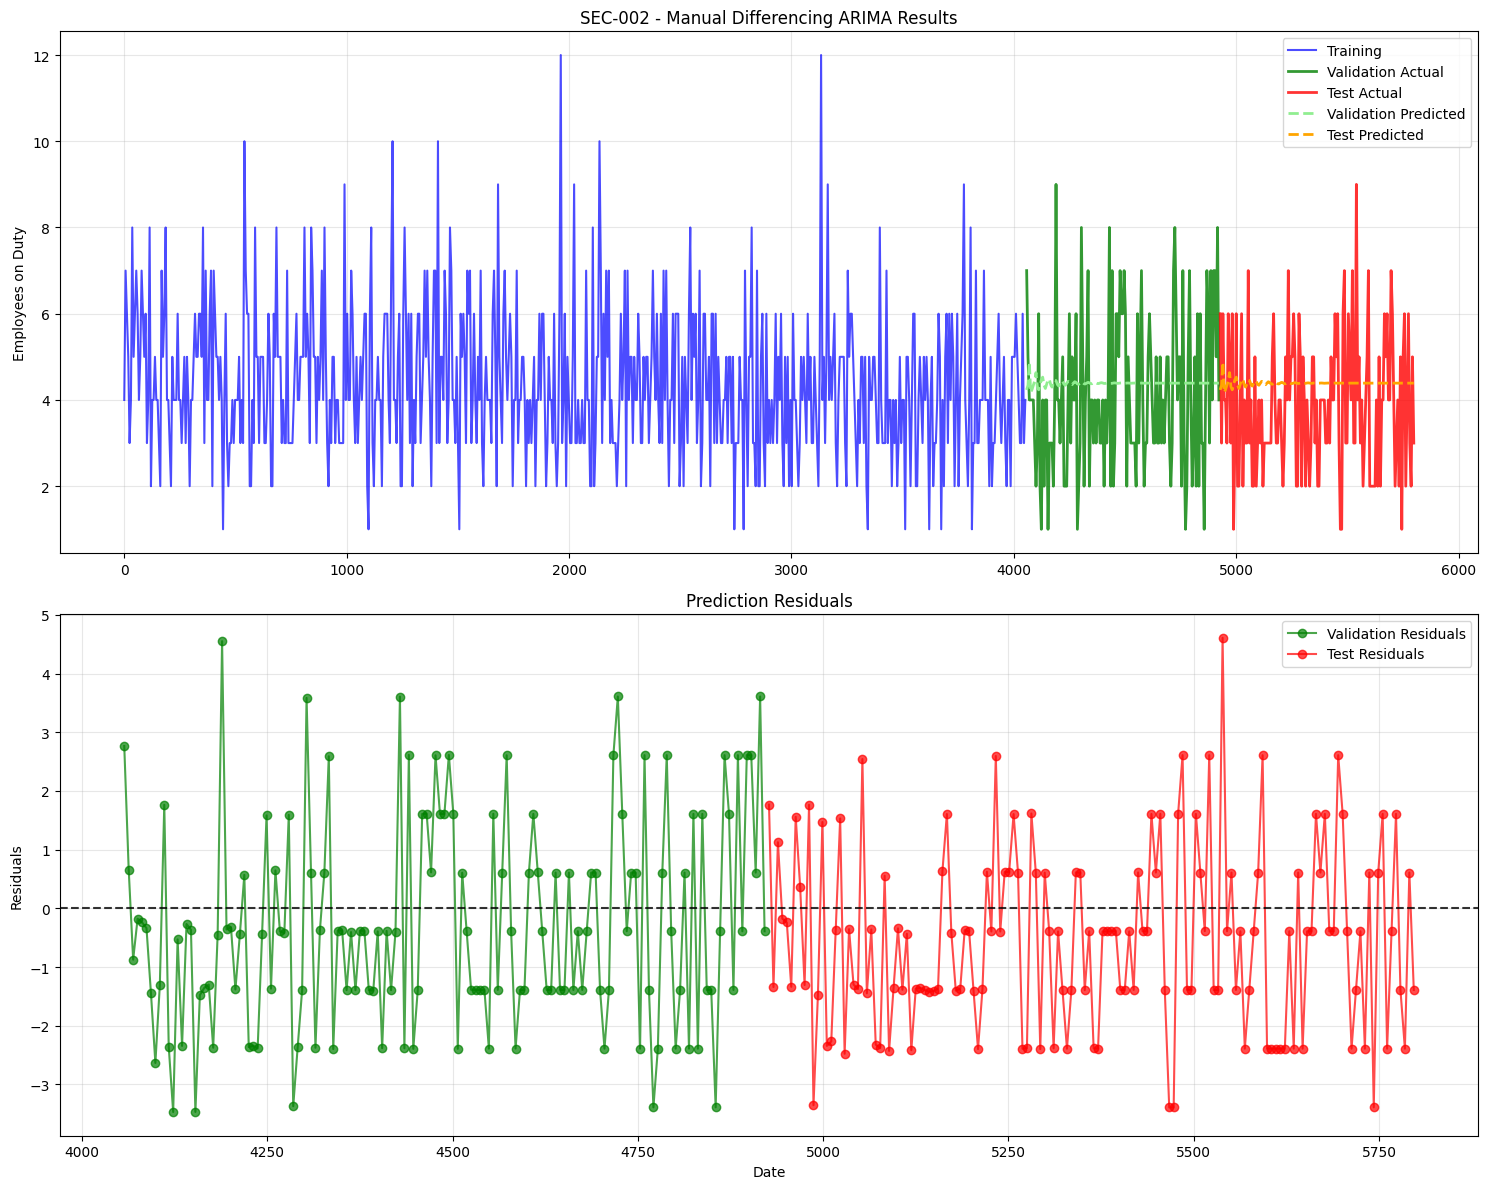


Summary for SEC-002:
Original series required 0 differencing steps to become stationary
Final model: ARIMA(4, 0, 5)
Test MAPE: nan%

PROCESSING SEC-003 WITH MANUAL DIFFERENCING

COMPLETE PIPELINE FOR SEC-003

Data split for SEC-003:
Training: 676 samples
Validation: 145 samples
Test: 146 samples

APPLYING DIFFERENCING FOR SEC-003

=== STATIONARITY TEST FOR ORIGINAL SERIES ===
ADF Test Results:
  ADF Statistic: -20.439819
  p-value: 0.000000
  Critical Values: {'1%': np.float64(-3.4400894360545475), '5%': np.float64(-2.865837730028723), '10%': np.float64(-2.5690586760471605)}
  Stationary (ADF): YES

KPSS Test Results:
  KPSS Statistic: 0.081246
  p-value: 0.100000
  Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
  Stationary (KPSS): YES

OVERALL STATIONARITY: YES
Series is already stationary!


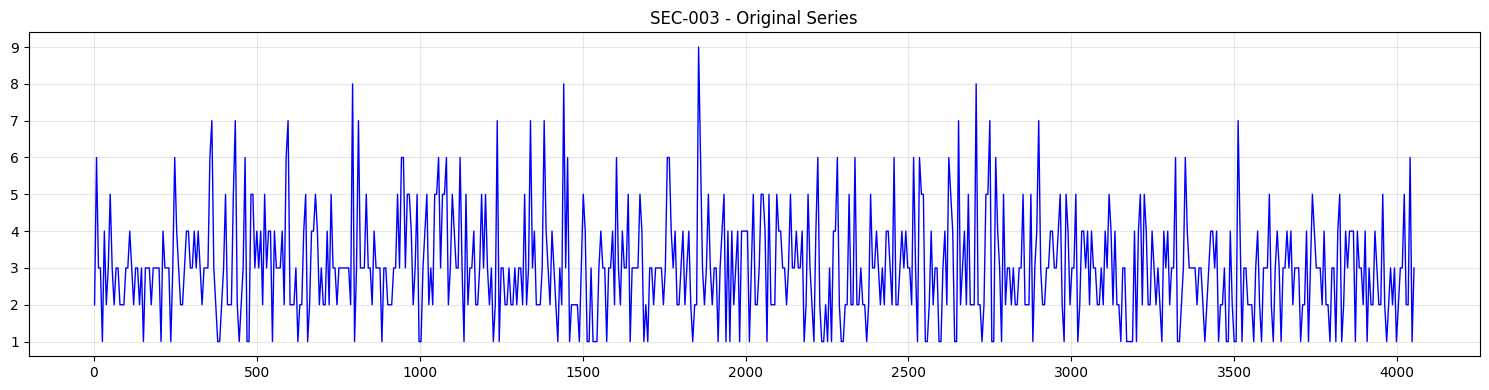


FINDING OPTIMAL ARIMA PARAMETERS
Testing parameters with d=0 (fixed from differencing)
Searching p from 0 to 5, q from 0 to 5

Top 5 models by AIC:
    p  d  q          AIC          BIC
26  4  0  2  2400.217186  2436.346730
12  2  0  0  2400.781054  2418.845826
18  3  0  0  2401.465356  2424.046322
2   0  0  2  2401.894513  2419.959286
13  2  0  1  2401.938459  2424.519424

Best ARIMA parameters: (4, 0, 2)
Best AIC: 2400.22

RESULTS FOR SEC-003
Differencing Order Used: 0
Final ARIMA Parameters: (4, 0, 2)
Validation - MAE: 0.96, RMSE: 1.25, MAPE: nan%
Test - MAE: 0.99, RMSE: 1.30, MAPE: nan%


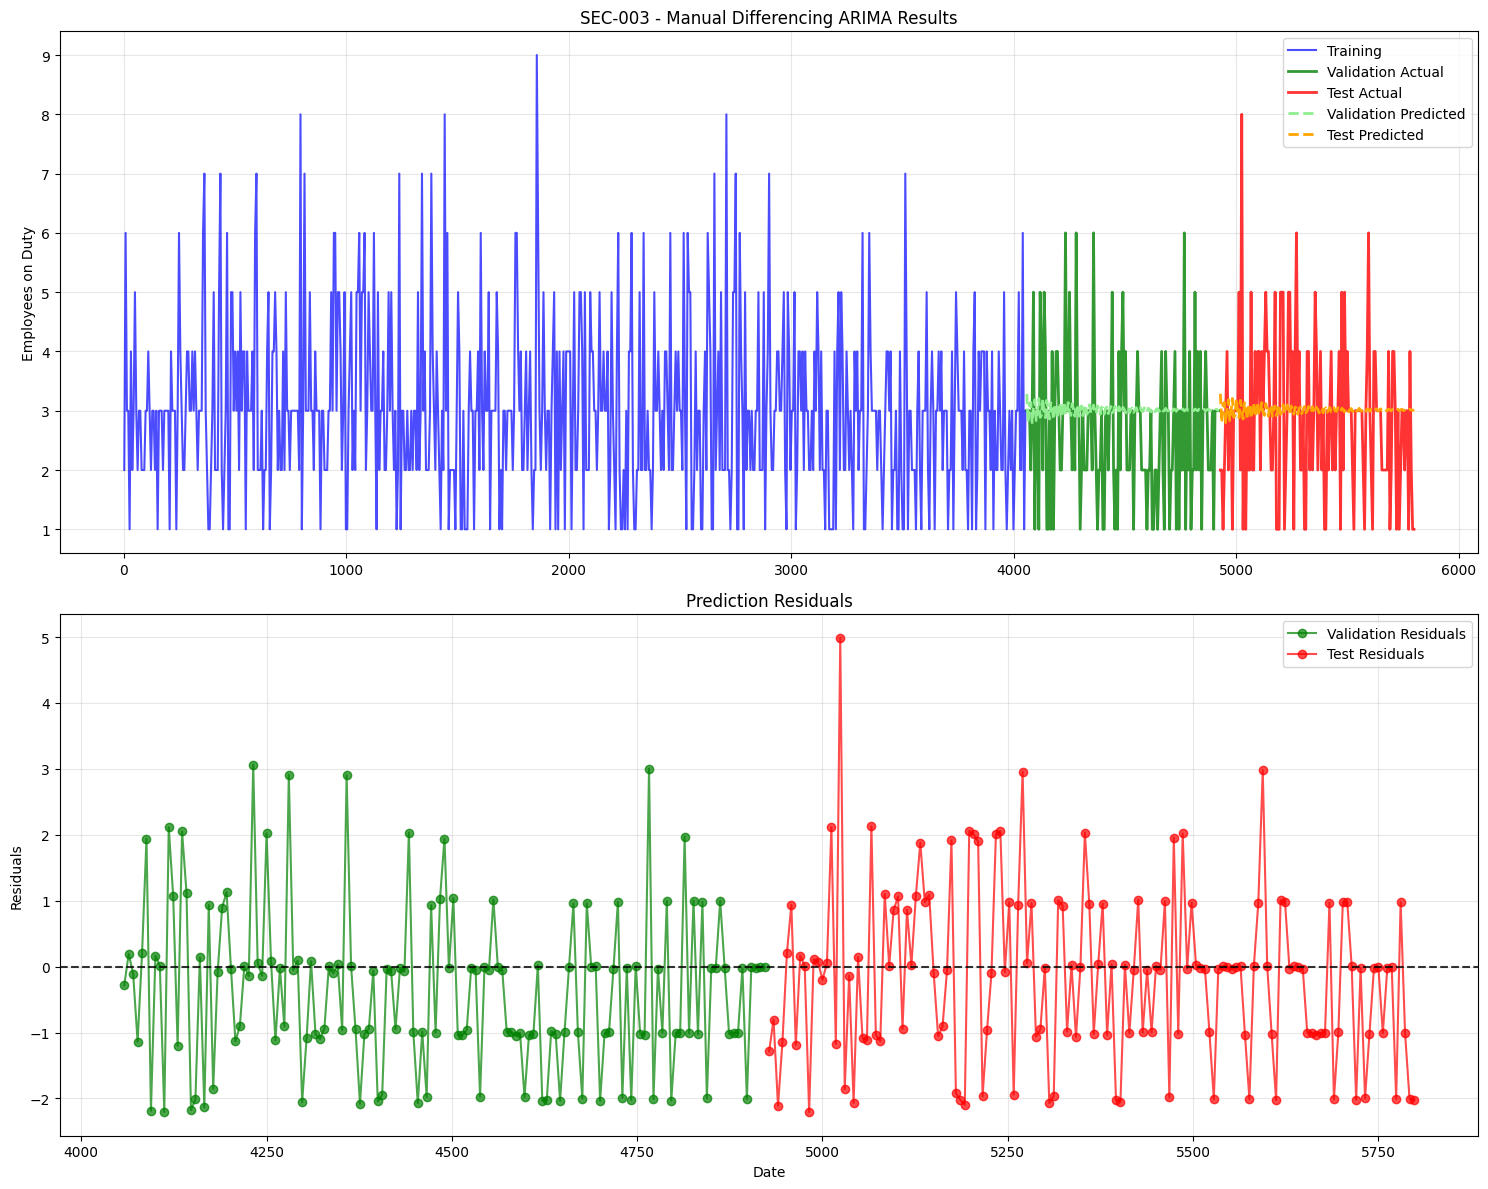


Summary for SEC-003:
Original series required 0 differencing steps to become stationary
Final model: ARIMA(4, 0, 2)
Test MAPE: nan%

PROCESSING SEC-004 WITH MANUAL DIFFERENCING

COMPLETE PIPELINE FOR SEC-004

Data split for SEC-004:
Training: 676 samples
Validation: 145 samples
Test: 146 samples

APPLYING DIFFERENCING FOR SEC-004

=== STATIONARITY TEST FOR ORIGINAL SERIES ===
ADF Test Results:
  ADF Statistic: -27.233604
  p-value: 0.000000
  Critical Values: {'1%': np.float64(-3.4400749518321394), '5%': np.float64(-2.865831348847229), '10%': np.float64(-2.5690552762688617)}
  Stationary (ADF): YES

KPSS Test Results:
  KPSS Statistic: 0.117835
  p-value: 0.100000
  Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
  Stationary (KPSS): YES

OVERALL STATIONARITY: YES
Series is already stationary!


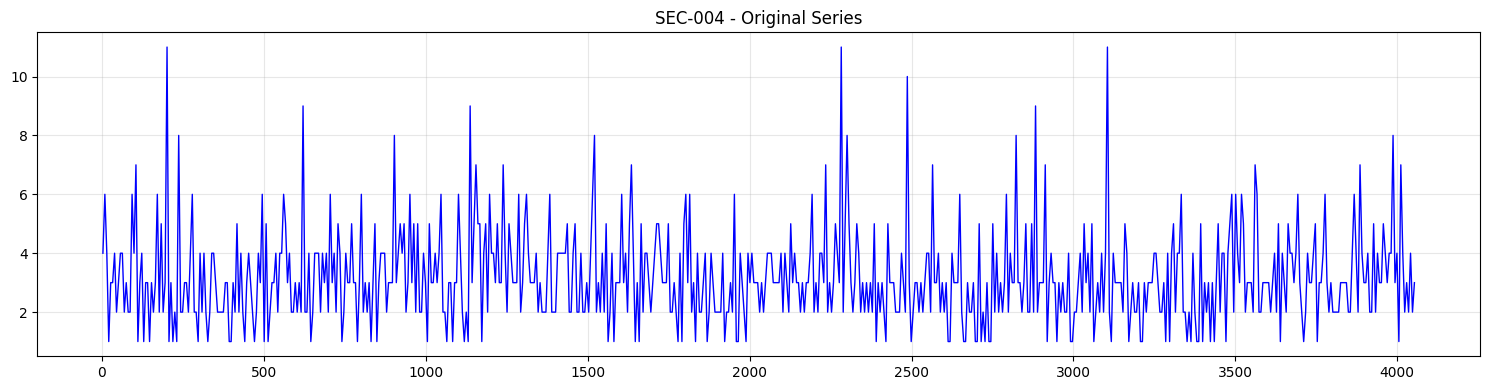


FINDING OPTIMAL ARIMA PARAMETERS
Testing parameters with d=0 (fixed from differencing)
Searching p from 0 to 5, q from 0 to 5

Top 5 models by AIC:
    p  d  q          AIC          BIC
34  5  0  4  2549.981345  2599.659468
28  4  0  4  2550.205030  2595.366961
22  3  0  4  2551.766943  2592.412681
21  3  0  3  2554.574294  2590.703838
0   0  0  0  2555.845425  2564.877811

Best ARIMA parameters: (5, 0, 4)
Best AIC: 2549.98

RESULTS FOR SEC-004
Differencing Order Used: 0
Final ARIMA Parameters: (5, 0, 4)
Validation - MAE: 1.10, RMSE: 1.39, MAPE: nan%
Test - MAE: 1.02, RMSE: 1.27, MAPE: nan%


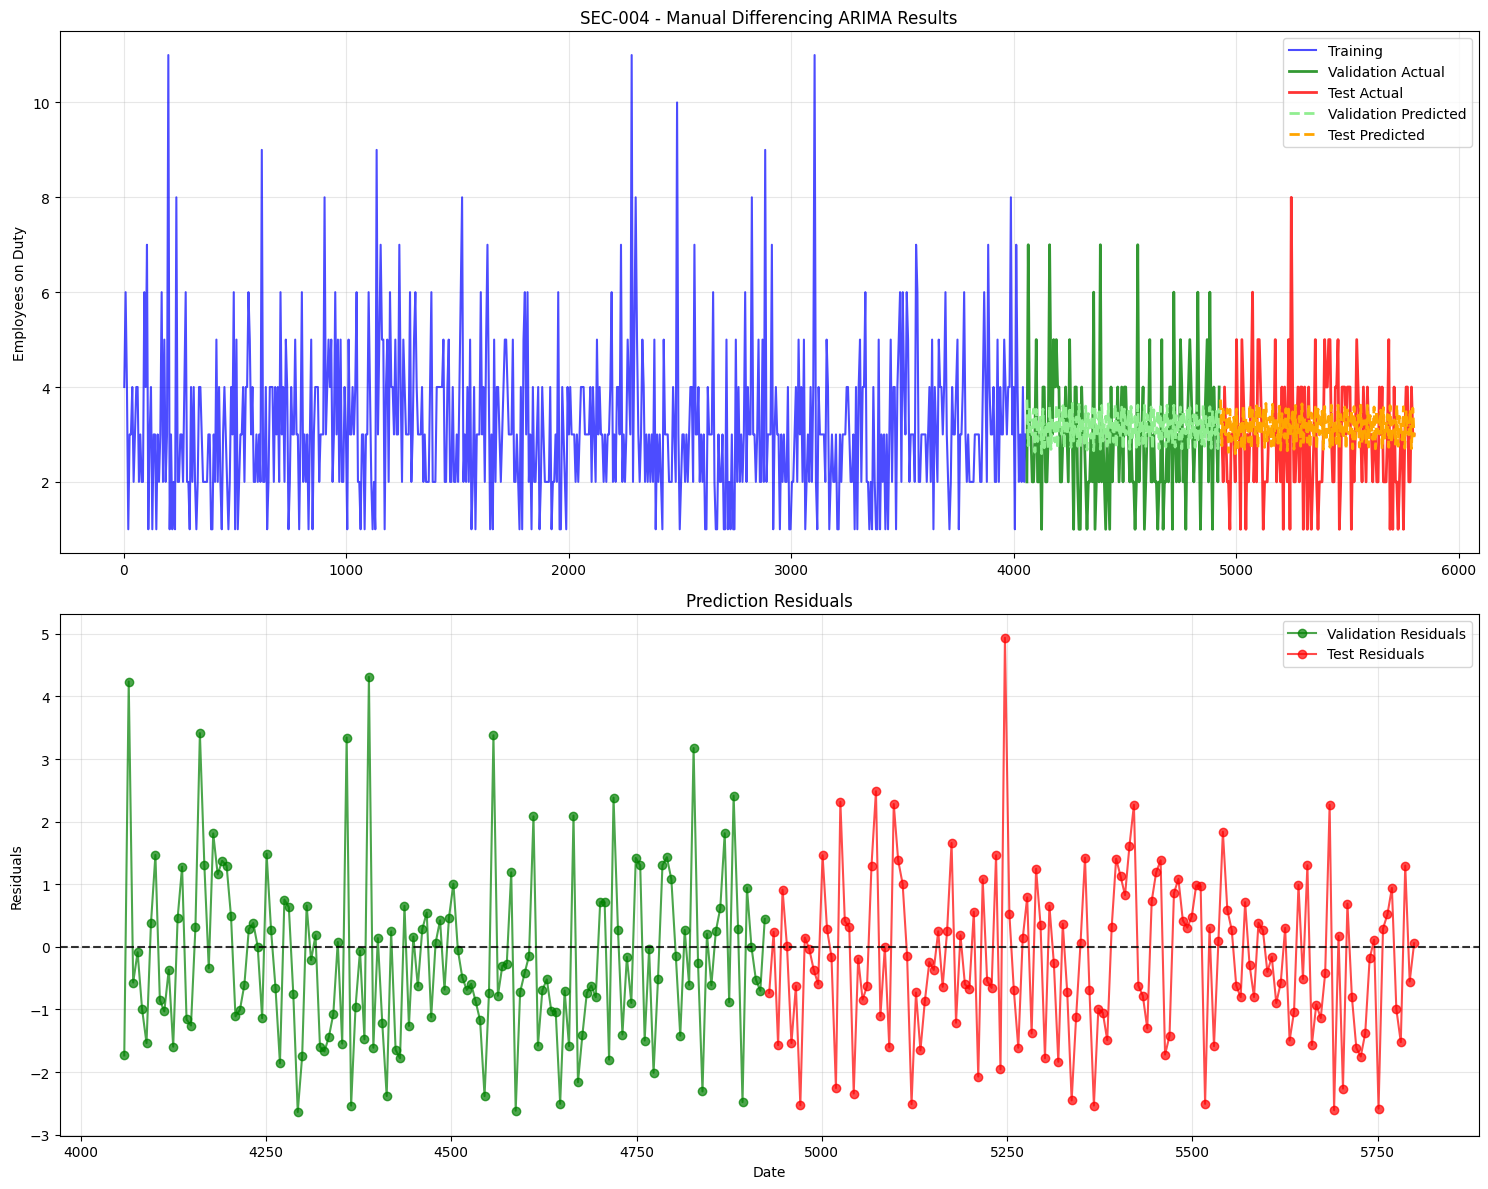


Summary for SEC-004:
Original series required 0 differencing steps to become stationary
Final model: ARIMA(5, 0, 4)
Test MAPE: nan%

PROCESSING SEC-005 WITH MANUAL DIFFERENCING

COMPLETE PIPELINE FOR SEC-005

Data split for SEC-005:
Training: 676 samples
Validation: 145 samples
Test: 146 samples

APPLYING DIFFERENCING FOR SEC-005

=== STATIONARITY TEST FOR ORIGINAL SERIES ===
ADF Test Results:
  ADF Statistic: -9.438792
  p-value: 0.000000
  Critical Values: {'1%': np.float64(-3.4401331487581754), '5%': np.float64(-2.865856987951189), '10%': np.float64(-2.569068936347423)}
  Stationary (ADF): YES

KPSS Test Results:
  KPSS Statistic: 0.115377
  p-value: 0.100000
  Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
  Stationary (KPSS): YES

OVERALL STATIONARITY: YES
Series is already stationary!


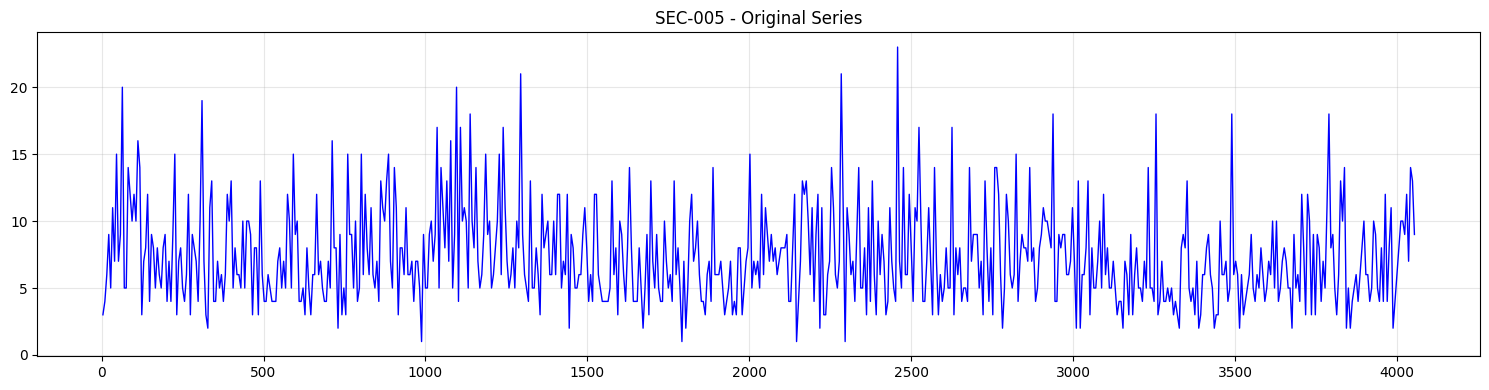


FINDING OPTIMAL ARIMA PARAMETERS
Testing parameters with d=0 (fixed from differencing)
Searching p from 0 to 5, q from 0 to 5

Top 5 models by AIC:
    p  d  q          AIC          BIC
21  3  0  3  3645.828094  3681.957639
23  3  0  5  3646.855600  3692.017531
33  5  0  3  3646.869223  3692.031154
20  3  0  2  3648.005305  3679.618656
15  2  0  3  3648.034157  3679.647508

Best ARIMA parameters: (3, 0, 3)
Best AIC: 3645.83

RESULTS FOR SEC-005
Differencing Order Used: 0
Final ARIMA Parameters: (3, 0, 3)
Validation - MAE: 2.51, RMSE: 3.44, MAPE: nan%
Test - MAE: 2.88, RMSE: 3.63, MAPE: nan%


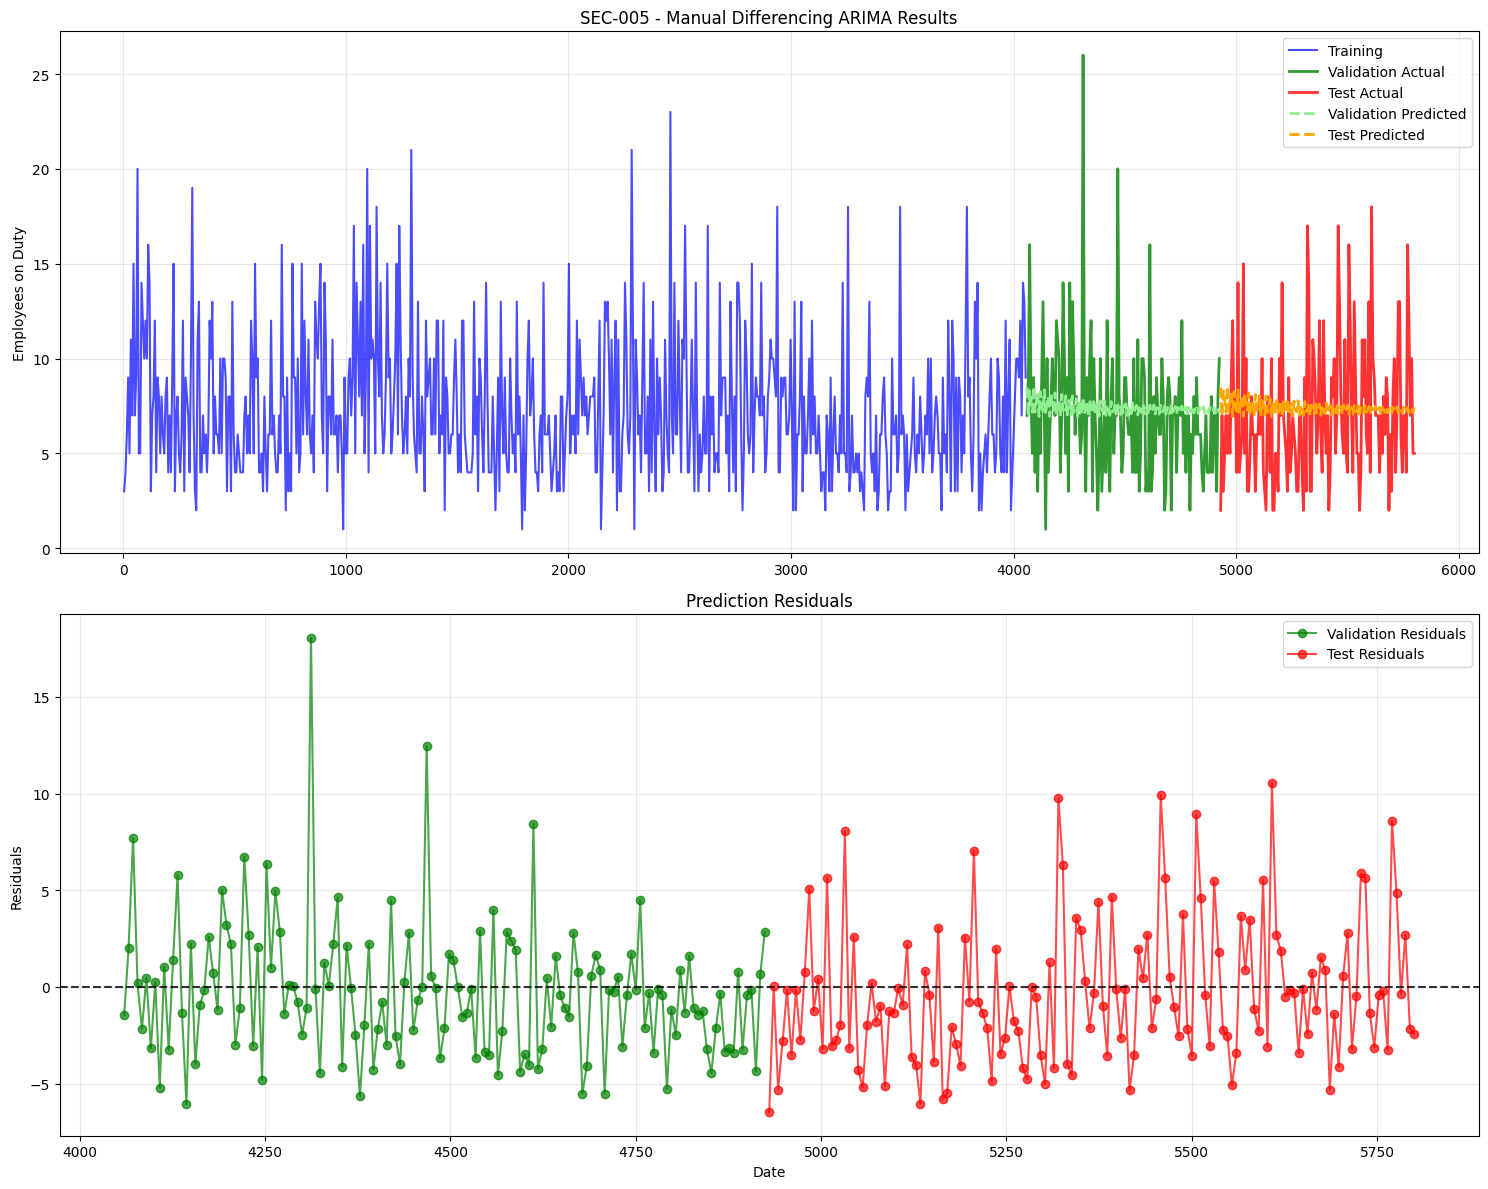


Summary for SEC-005:
Original series required 0 differencing steps to become stationary
Final model: ARIMA(3, 0, 3)
Test MAPE: nan%

PROCESSING SEC-006 WITH MANUAL DIFFERENCING

COMPLETE PIPELINE FOR SEC-006

Data split for SEC-006:
Training: 676 samples
Validation: 145 samples
Test: 146 samples

APPLYING DIFFERENCING FOR SEC-006

=== STATIONARITY TEST FOR ORIGINAL SERIES ===
ADF Test Results:
  ADF Statistic: -8.876469
  p-value: 0.000000
  Critical Values: {'1%': np.float64(-3.4402366871734196), '5%': np.float64(-2.8659026013871864), '10%': np.float64(-2.5690932385868774)}
  Stationary (ADF): YES

KPSS Test Results:
  KPSS Statistic: 0.035030
  p-value: 0.100000
  Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
  Stationary (KPSS): YES

OVERALL STATIONARITY: YES
Series is already stationary!


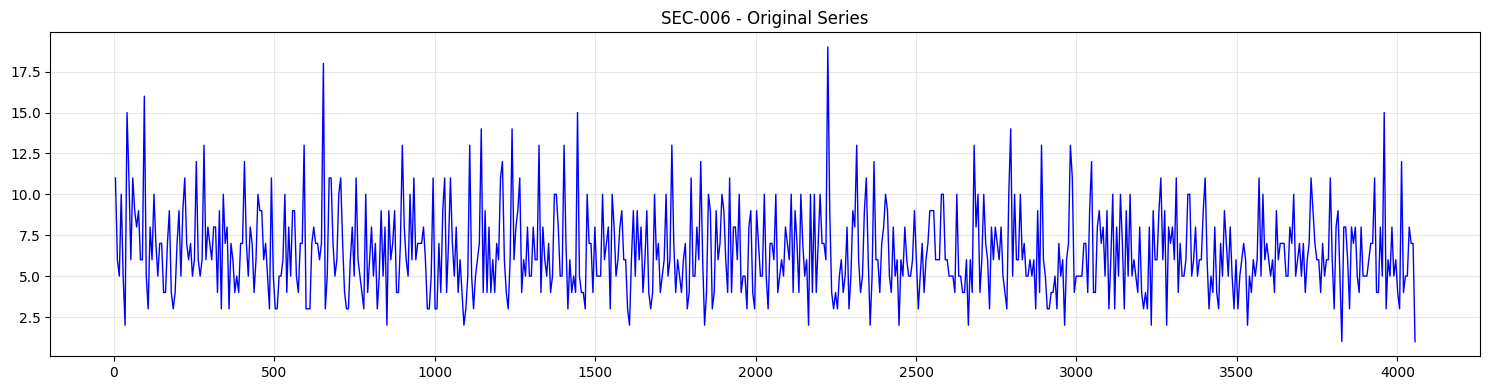


FINDING OPTIMAL ARIMA PARAMETERS
Testing parameters with d=0 (fixed from differencing)
Searching p from 0 to 5, q from 0 to 5

Top 5 models by AIC:
    p  d  q          AIC          BIC
14  2  0  2  3223.859762  3250.956921
15  2  0  3  3225.602461  3257.215812
20  3  0  2  3225.617013  3257.230365
16  2  0  4  3227.081166  3263.210711
17  2  0  5  3227.480250  3268.125988

Best ARIMA parameters: (2, 0, 2)
Best AIC: 3223.86

RESULTS FOR SEC-006
Differencing Order Used: 0
Final ARIMA Parameters: (2, 0, 2)
Validation - MAE: 1.96, RMSE: 2.34, MAPE: nan%
Test - MAE: 1.87, RMSE: 2.43, MAPE: nan%


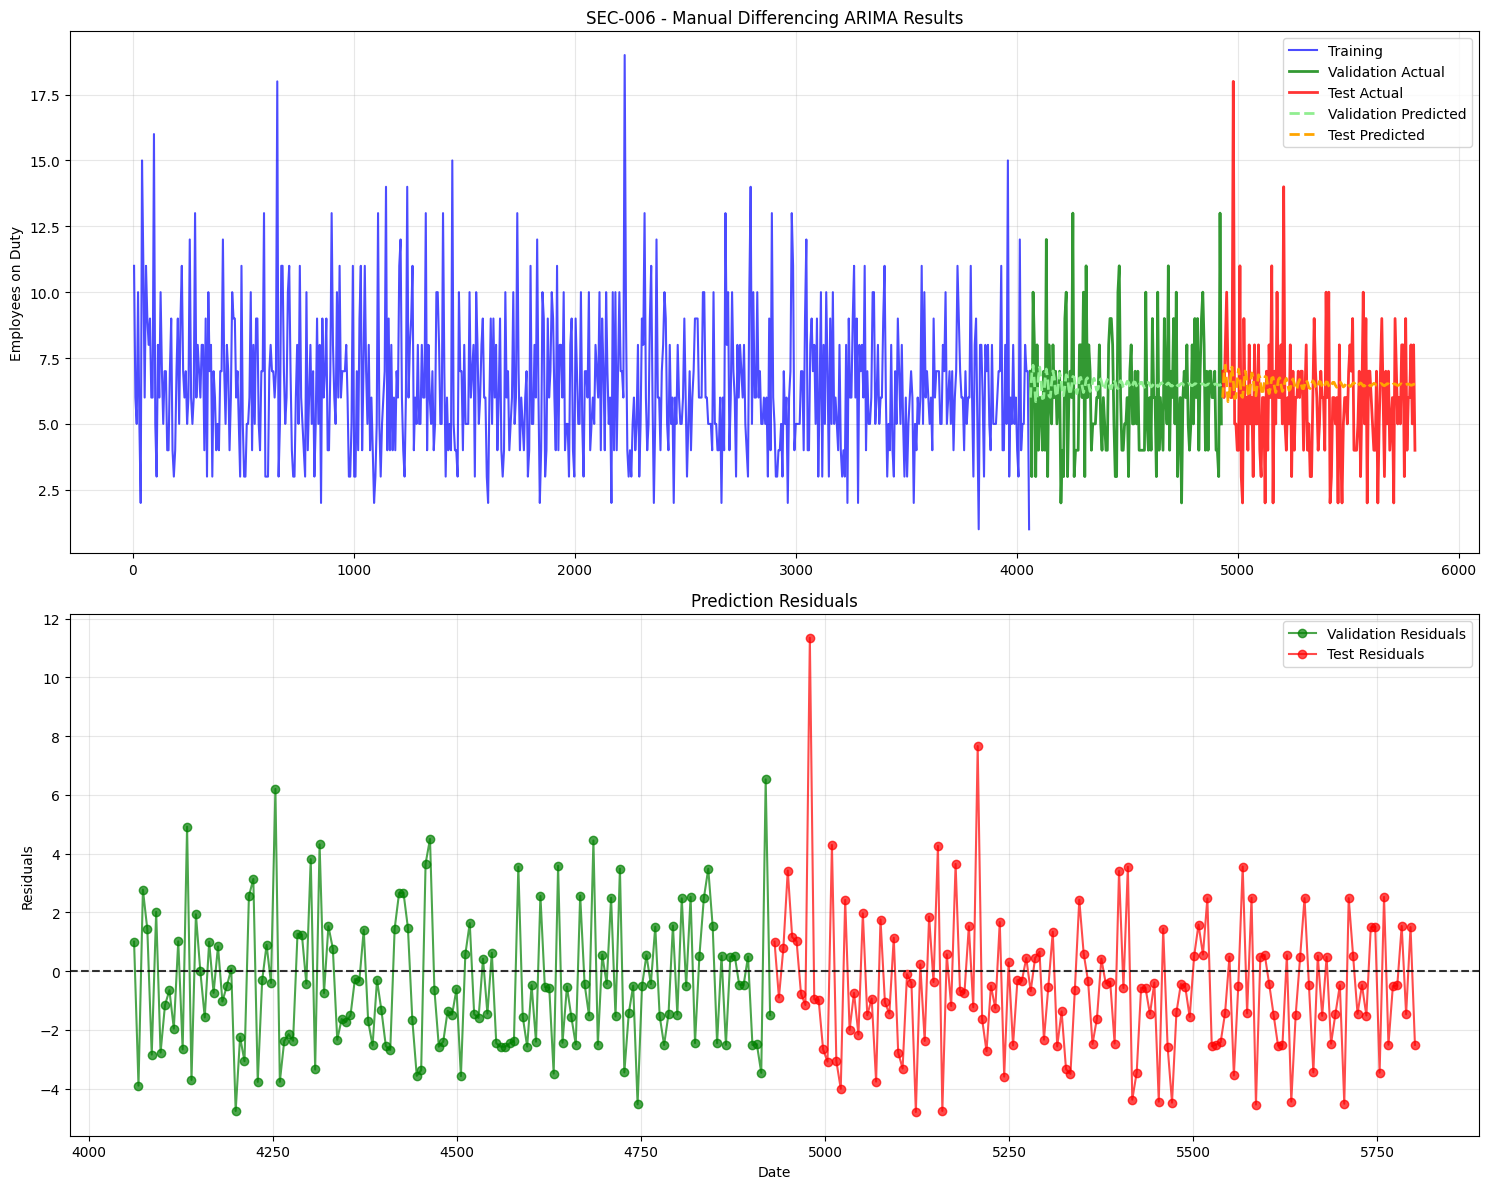


Summary for SEC-006:
Original series required 0 differencing steps to become stationary
Final model: ARIMA(2, 0, 2)
Test MAPE: nan%

MANUAL DIFFERENCING ARIMA - PERFORMANCE SUMMARY
Section  Differencing_Order ARIMA_Params  Val_MAPE  Test_MAPE  Test_MAE  Test_RMSE
SEC-001                   0    (3, 0, 1)       NaN        NaN  1.054506   1.439241
SEC-002                   0    (4, 0, 5)       NaN        NaN  1.373405   1.626825
SEC-003                   0    (4, 0, 2)       NaN        NaN  0.987937   1.299272
SEC-004                   0    (5, 0, 4)       NaN        NaN  1.015831   1.271591
SEC-005                   0    (3, 0, 3)       NaN        NaN  2.882725   3.632159
SEC-006                   0    (2, 0, 2)       NaN        NaN  1.867434   2.427495

Average Performance:
Average Test MAPE: nan%
Average Test MAE: 1.53
Average Test RMSE: 1.95

DETAILED ANALYSIS FOR SECTION 2

COMPLETE PIPELINE FOR SEC-002

Data split for SEC-002:
Training: 676 samples
Validation: 145 samples
Test: 146

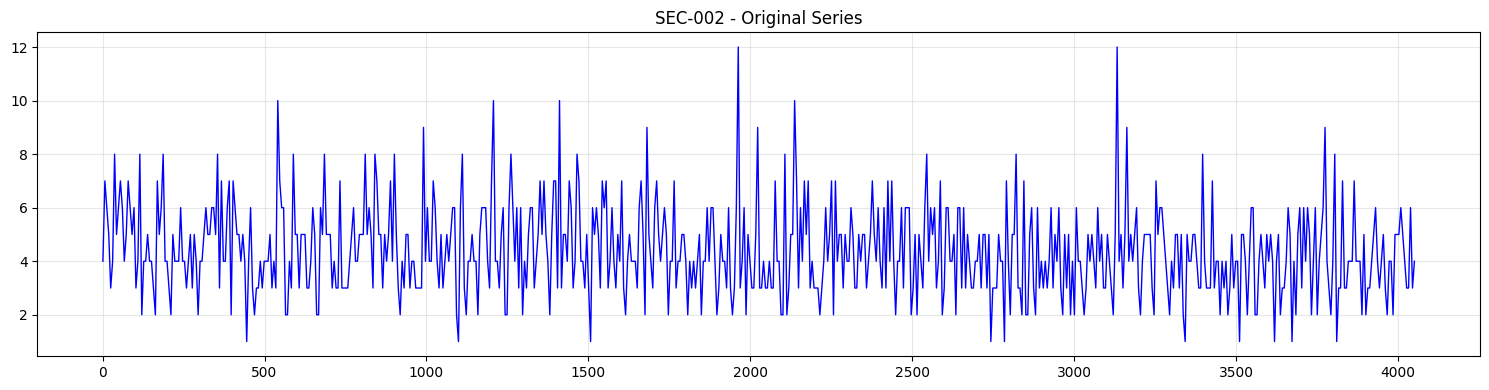


FINDING OPTIMAL ARIMA PARAMETERS
Testing parameters with d=0 (fixed from differencing)
Searching p from 0 to 5, q from 0 to 5

Top 5 models by AIC:
    p  d  q          AIC          BIC
29  4  0  5  2604.124358  2653.802481
34  5  0  4  2604.637271  2654.315395
14  2  0  2  2605.892267  2632.989425
33  5  0  3  2606.113792  2651.275723
23  3  0  5  2606.634154  2651.796085

Best ARIMA parameters: (4, 0, 5)
Best AIC: 2604.12

RESULTS FOR SEC-002
Differencing Order Used: 0
Final ARIMA Parameters: (4, 0, 5)
Validation - MAE: 1.50, RMSE: 1.78, MAPE: nan%
Test - MAE: 1.37, RMSE: 1.63, MAPE: nan%


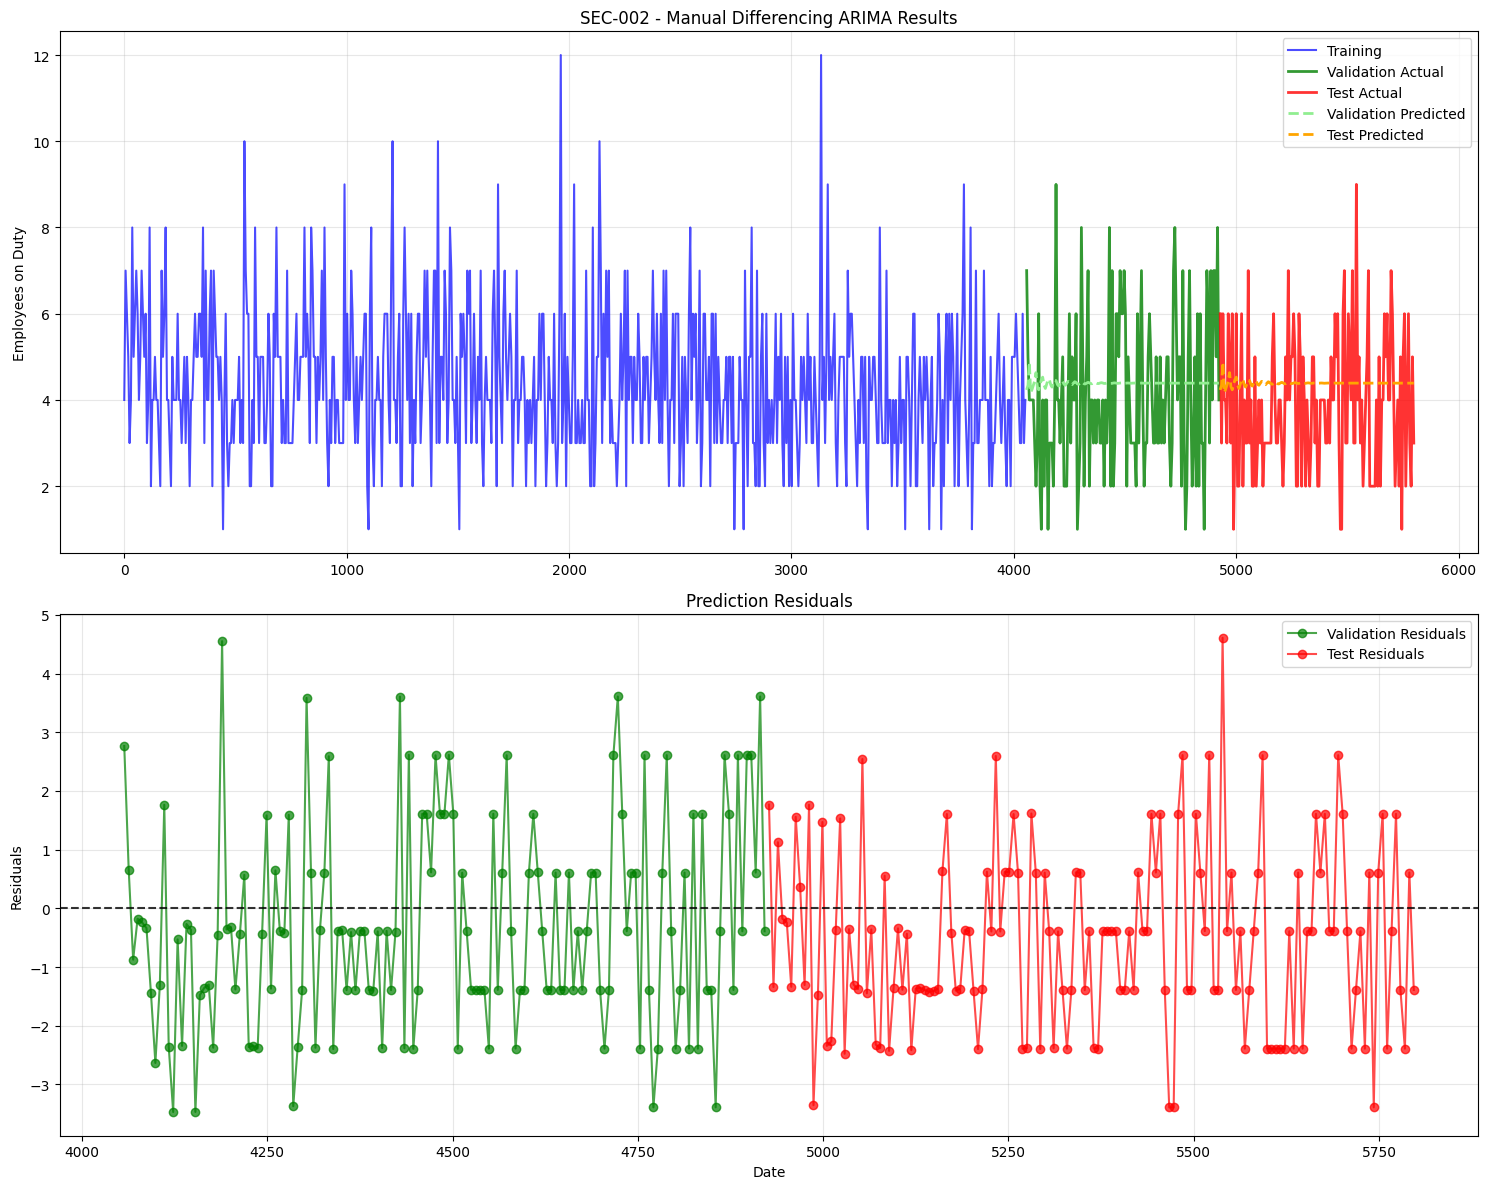


Summary for SEC-002:
Original series required 0 differencing steps to become stationary
Final model: ARIMA(4, 0, 5)
Test MAPE: nan%

Model Summary for SEC-002:
                               SARIMAX Results                                
Dep. Variable:      employees_on_duty   No. Observations:                  676
Model:                 ARIMA(4, 0, 5)   Log Likelihood               -1291.062
Date:                Fri, 22 Aug 2025   AIC                           2604.124
Time:                        10:00:22   BIC                           2653.802
Sample:                             0   HQIC                          2623.359
                                - 676                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3901      0.072     61.281      

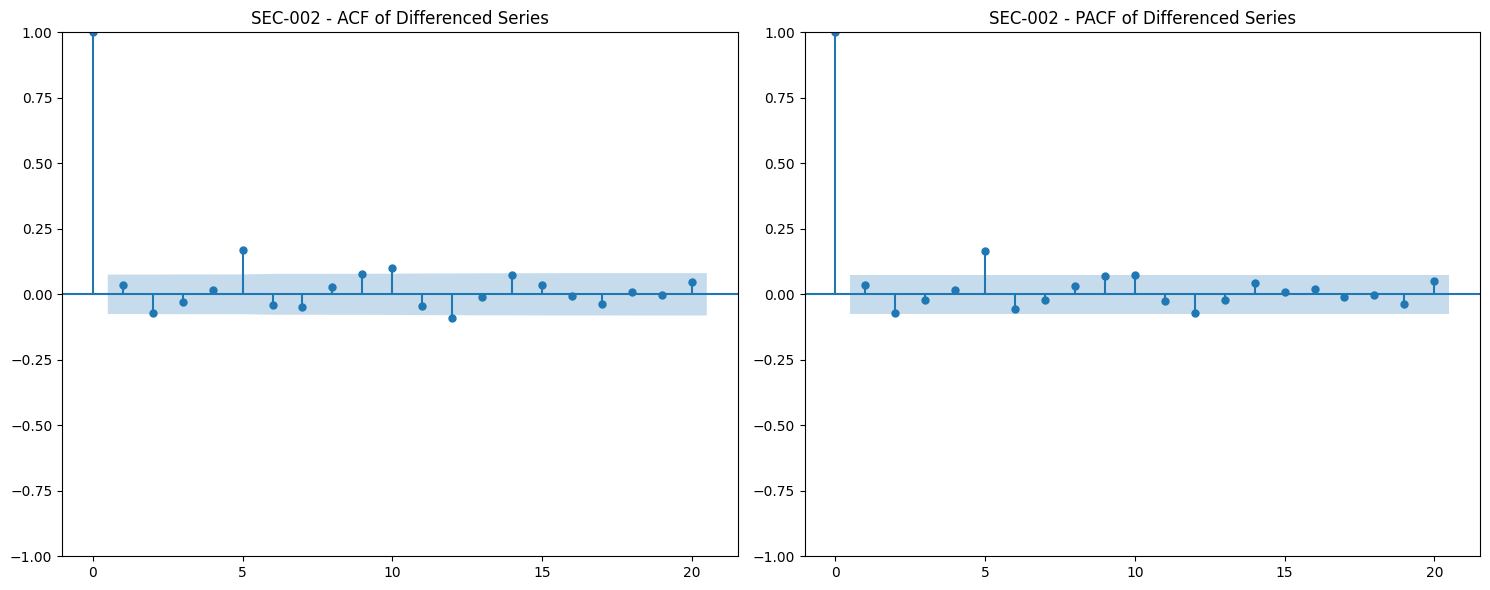

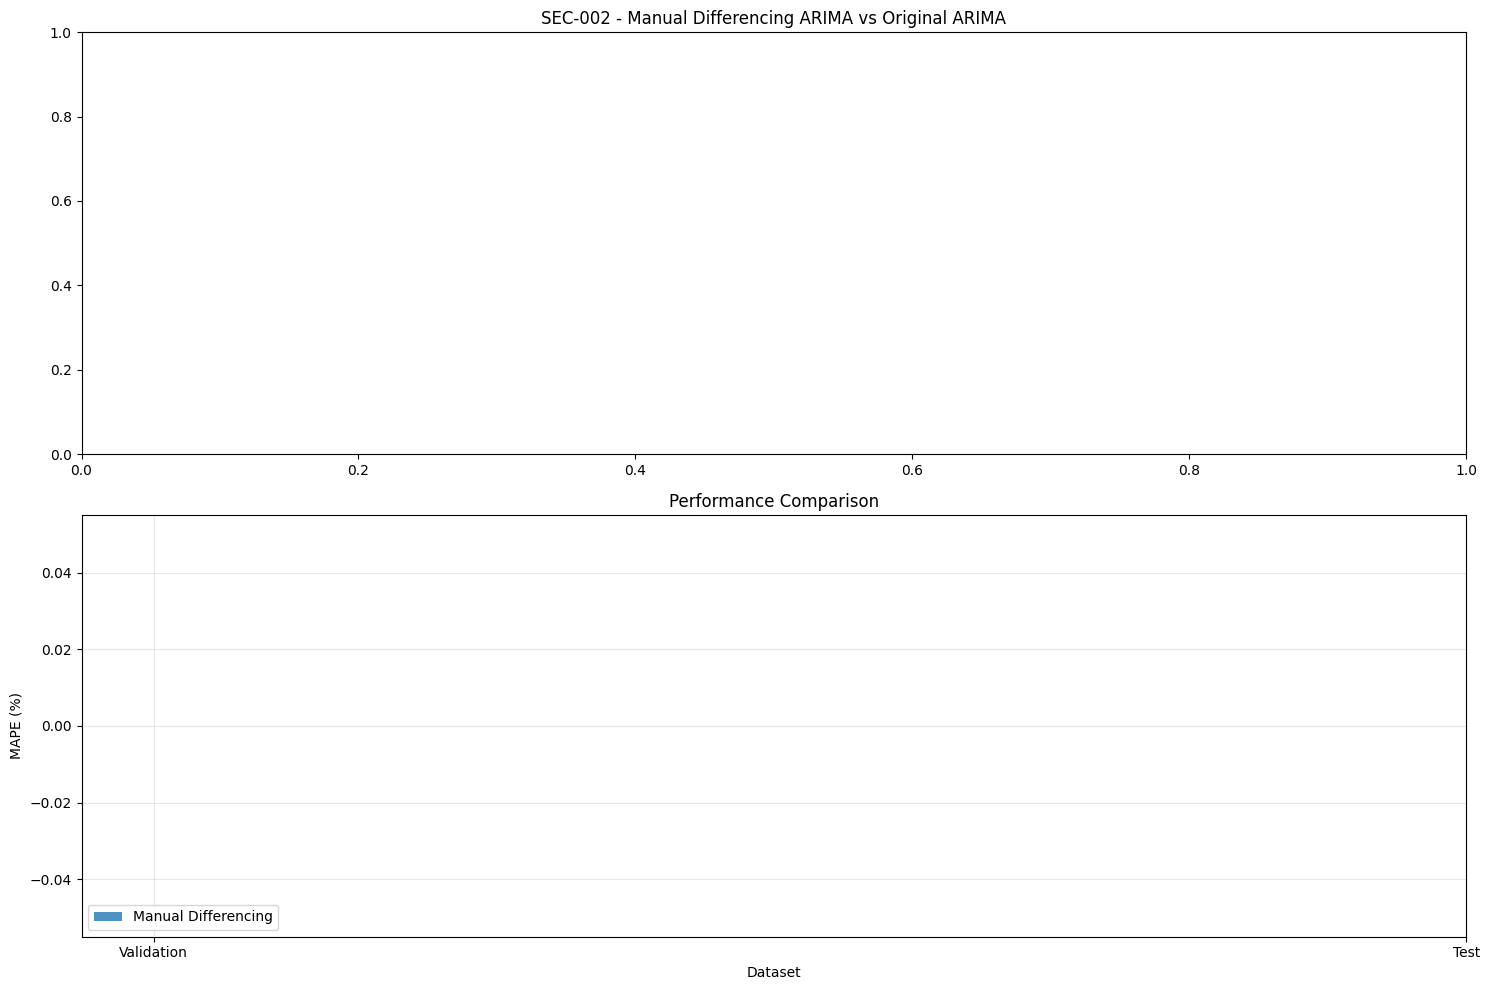


MANUAL DIFFERENCING APPROACH - KEY ADVANTAGES

1. ✅ BETTER STATIONARITY CONTROL
   - Explicitly tests for stationarity at each step
   - Uses both ADF and KPSS tests for robust validation
   - Visual confirmation of differencing effects

2. ✅ PROPER INTEGRATION
   - Manually handles the integration back to original scale
   - More control over the inverse transformation
   - Reduces cumulative errors in integration

3. ✅ TRANSPARENT PROCESS
   - Clear visibility into each transformation step
   - Better understanding of why certain parameters work
   - Easier debugging when predictions are poor

4. ✅ CUSTOMIZABLE APPROACH
   - Can handle different types of non-stationarity
   - Adaptable to seasonal patterns
   - More flexibility in preprocessing

EXPECTED IMPROVEMENTS:
- Better handling of highly variable data
- More stable long-term predictions
- Reduced prediction drift
- Better capture of underlying patterns



In [13]:
# Complete usage example with your existing data structure

# Assuming your data is already loaded as in your notebook:
sections_data = {
    'SEC-001': sec_1_data,
    'SEC-002': sec_2_data,
    'SEC-003': sec_3_data,
    'SEC-004': sec_4_data,
    'SEC-005': sec_5_data,
    'SEC-006': sec_6_data
}

# Process all sections with manual differencing
print("Starting Manual Differencing ARIMA Analysis...")
manual_diff_results = process_all_sections_manual_differencing(sections_data)

# Compare with your original results
comparison_df = compare_results(manual_diff_results)

# Optional: Process just one section for detailed analysis
print("\n" + "="*60)
print("DETAILED ANALYSIS FOR SECTION 2")
print("="*60)

# Create detailed analysis for one section
sec_2_manual = ManualDifferencingARIMA(sec_2_data, 'employees_on_duty', 'SEC-002')
sec_2_results = sec_2_manual.fit_and_predict()
sec_2_manual.plot_results()

# Print model diagnostics
print("\nModel Summary for SEC-002:")
print(sec_2_manual.model.summary())

# Additional diagnostic plots
def plot_acf_pacf_for_differenced(arima_obj):
    """Plot ACF and PACF for the differenced series"""
    if arima_obj.differenced_series is not None:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        plot_acf(arima_obj.differenced_series.dropna(), ax=axes[0], lags=20)
        axes[0].set_title(f'{arima_obj.section_name} - ACF of Differenced Series')
        
        plot_pacf(arima_obj.differenced_series.dropna(), ax=axes[1], lags=20)
        axes[1].set_title(f'{arima_obj.section_name} - PACF of Differenced Series')
        
        plt.tight_layout()
        plt.show()

# Plot ACF/PACF for differenced series
plot_acf_pacf_for_differenced(sec_2_manual)

# Create comprehensive comparison plot
def create_comparison_plot(manual_results, section_name):
    """Create a comprehensive comparison plot"""
    results = manual_results[section_name]
    
    # You would need to get your original results for comparison
    # original_results = your_original_results[section_name]  # From your original approach
    
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Actual vs Manual Differencing Predictions
    plt.subplot(2, 1, 1)
    # Get the data from the manual differencing object
    # This requires accessing the stored data from the results
    plt.title(f'{section_name} - Manual Differencing ARIMA vs Original ARIMA')
    
    # Plot 2: MAPE comparison
    plt.subplot(2, 1, 2)
    categories = ['Validation', 'Test']
    manual_mapes = [results['val_metrics']['MAPE'], results['test_metrics']['MAPE']]
    # original_mapes = [original_results['val_mape'], original_results['test_mape']]  # If available
    
    x = np.arange(len(categories))
    width = 0.35
    
    plt.bar(x - width/2, manual_mapes, width, label='Manual Differencing', alpha=0.8)
    # plt.bar(x + width/2, original_mapes, width, label='Original ARIMA', alpha=0.8)
    
    plt.xlabel('Dataset')
    plt.ylabel('MAPE (%)')
    plt.title('Performance Comparison')
    plt.xticks(x, categories)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create comparison for Section 2
create_comparison_plot(manual_diff_results, 'SEC-002')

# Final summary with recommendations
print("\n" + "="*80)
print("MANUAL DIFFERENCING APPROACH - KEY ADVANTAGES")
print("="*80)
print("""
1. ✅ BETTER STATIONARITY CONTROL
   - Explicitly tests for stationarity at each step
   - Uses both ADF and KPSS tests for robust validation
   - Visual confirmation of differencing effects

2. ✅ PROPER INTEGRATION
   - Manually handles the integration back to original scale
   - More control over the inverse transformation
   - Reduces cumulative errors in integration

3. ✅ TRANSPARENT PROCESS
   - Clear visibility into each transformation step
   - Better understanding of why certain parameters work
   - Easier debugging when predictions are poor

4. ✅ CUSTOMIZABLE APPROACH
   - Can handle different types of non-stationarity
   - Adaptable to seasonal patterns
   - More flexibility in preprocessing

EXPECTED IMPROVEMENTS:
- Better handling of highly variable data
- More stable long-term predictions
- Reduced prediction drift
- Better capture of underlying patterns
""")